In [ ]:
import os, sys
import pandas as pd 
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from rwr_functions import *
import hiperwalk as hpw
import random
from collections import defaultdict
import itertools
from gensim.models import Word2Vec
from node2vec import Node2Vec
from scipy.linalg import orthogonal_procrustes
from numpy.linalg import svd, eigh
from sklearn.cross_decomposition import CCA 
from scipy.spatial.distance import pdist, squareform 
from scipy.stats import spearmanr
from sklearn.neighbors import NearestNeighbors


In [2]:
path = '../Aug21/GWAS_NetworkPropagation/processed_data/networks/'
network_files = {
    "BioPlex3": path+"BioPlex3_shared/edges_list_ncbi.csv",
    "HumanNet": path+"HumanNetV3/edges_list_ncbi.csv",
    "PCNet": path+"PCNet/edges_list_ncbi.csv",
    "ProteomeHD": path+"ProteomeHD/edges_list_ncbi.csv",
    "STRING": path+"STRING/edges_list_ncbi.csv",
}

networks = ['ProteomeHD','BioPlex3','STRING','HumanNet','PCNet']
diseases = ['asthma','autism','schizophrenia']

In [3]:
def load_giant(network):
    """
    Loads the largest connected component (giant component) of a network from a CSV file.

    """
    df = pd.read_csv(network_files[network], dtype={'node1': str, 'node2': str})[["node1", "node2"]]
    graph = nx.from_pandas_edgelist(df, source="node1", target="node2")
    # Find the largest connected component in the graph
    giant = max(nx.connected_components(graph), key=len)
    graph = graph.subgraph(giant)
    
    return graph

def get_stats(G): 
    stats = {}
    stats['num_nodes'] = G.number_of_nodes()
    stats['num_edges'] = G.number_of_edges()
    stats['density'] = nx.density(G)
    stats['num_connected_components'] = nx.number_connected_components(G)
    largest_cc = max(nx.connected_components(G), key=len)
    stats['largest_cc_size'] = len(largest_cc)
    stats['average_clustering_coefficient'] = nx.average_clustering(G)
    degrees = [d for n, d in G.degree()]
    stats['average_degree'] = np.mean(degrees)
    stats['degree_assortativity_coefficient'] = nx.degree_assortativity_coefficient(G)
    betweenness = list(nx.betweenness_centrality(G).values())
    stats['average_clustering_coefficient'] = np.mean(betweenness)
    
    return stats

def draw_graph(G, source=None, target=None, title="Graph"):
    plt.figure(figsize=(8, 8))
    pos = nx.spring_layout(G)
    default_color = "#185e8d"
    d = dict(G.degree())
    node_colors = [default_color] * len(G.nodes)
    node_to_index = {node:i for i, node in enumerate(G.nodes)}
    if source is None and target is None:
        nx.draw_networkx(G, 
                pos = pos, 
                with_labels=True,
                nodelist=list(d.keys()), 
                node_color=node_colors,
                node_size=[v*6 for v in d.values()],
                width=2)
    else: 
        for s,t in zip(source, target):
            for i, node in enumerate([s,t]): 
                if node in node_to_index:
                    if i == 0:
                        node_colors[node_to_index[node]] = 'red'
                    elif i == 1: 
                        node_colors[node_to_index[node]] = 'green'
                else:
                    print(f"Node {node} not found in graph")
        nx.draw_networkx(G, 
                pos = pos, 
                with_labels=False,
                nodelist=list(d.keys()), 
                node_color=node_colors,
                node_size=[v*6 for v in d.values()],
                width=2)
    plt.title(title)
    plt.show()
    

In [4]:
stats_dict = {}
network = networks[0]
graph = load_giant(network) 
print(f"Network: {network}")
stats_dict[network] = get_stats(graph)

Network: ProteomeHD


In [5]:
stats_dict

{'ProteomeHD': {'num_nodes': 2471,
  'num_edges': 62598,
  'density': 0.020512602054274933,
  'num_connected_components': 1,
  'largest_cc_size': 2471,
  'average_clustering_coefficient': 0.0014310752143462061,
  'average_degree': 50.666127074059084,
  'degree_assortativity_coefficient': 0.31202246925157145}}

In [6]:
disease = 'schizophrenia'
pegasus_data = load_pegasus_results(disease)
gene_seeds_ncbi, ncbi_targets = load_seeds_and_targets(disease)
ncbi_targets = [x for x in graph.nodes if x in ncbi_targets]
pegasus_scores = dict(zip(pegasus_data["NCBI_id"], pegasus_data["Score"]))
pagerank_seeds = {node: pegasus_scores.get(node, 0) for node in graph.nodes}
ncbi2gene = dict(zip(pegasus_data["NCBI_id"], pegasus_data["Gene"]))

source = [x for x,y in pagerank_seeds.items() if y>0.3*pd.Series(pagerank_seeds).max()]
genes = [x for x in source if x not in gene_seeds_ncbi]

In [7]:
print(f"Seed genes: {len(gene_seeds_ncbi)}, targets: {len(ncbi_targets)}") 
len(source), len(genes)

Seed genes: 536, targets: 78


(107, 49)

In [8]:
def build_seed_neighborhood_subgraph(
    graph,
    seed_nodes,
    max_hops=4,
    max_nodes=500,
    random_state=None
):
    """
    Build ss_nodes = seeds ∪ neighbors up to max_hops,
    stopping once max_nodes is reached.
    
    Parameters
    ----------
    graph : nx.Graph
        Full PPI graph
    seed_nodes : iterable
        Seed genes (must be in graph)
    max_hops : int
        Maximum hop expansion (default=4)
    max_nodes : int
        Cap on total nodes (default=500)
    random_state : int or None
        For reproducibility
    
    Returns
    -------
    ss_nodes : set
        Selected node set
    """

    if random_state is not None:
        random.seed(random_state)

    # Keep only seeds present in the graph
    seeds = set(seed_nodes).intersection(graph.nodes)
    ss_nodes = set(seeds)

    # Frontier for BFS-style expansion
    frontier = set(seeds)

    for hop in range(1, max_hops + 1):
        if len(ss_nodes) >= max_nodes or not frontier:
            break

        next_frontier = set()

        for u in frontier:
            next_frontier.update(graph.neighbors(u))

        # Remove already-seen nodes
        next_frontier -= ss_nodes

        if not next_frontier:
            break

        # If adding all neighbors exceeds cap, sample
        remaining_slots = max_nodes - len(ss_nodes)
        if len(next_frontier) > remaining_slots:
            next_frontier = set(random.sample(list(next_frontier), remaining_slots))

        ss_nodes.update(next_frontier)
        frontier = next_frontier

    return ss_nodes

In [9]:

#nodes = list(graph.nodes)
#print(f"Total nodes in graph: {len(nodes)}")
#ss_nodes = random.sample(nodes, 400)
#ss_seeds = random.sample(gene_seeds_ncbi, 25)
#ss_targets = random.sample(ncbi_targets, 40)
#ss_nodes = list(set(ss_nodes + ss_seeds + ss_targets))

# ss_graph = graph.subgraph(ss_nodes)
# ss_giant = max(nx.connected_components(ss_graph), key=len)
# subgraph = graph.subgraph(ss_giant)
ss_seeds = random.sample(gene_seeds_ncbi, 25)
ss_nodes = build_seed_neighborhood_subgraph(graph=graph,
                                            seed_nodes=ss_seeds,
                                            max_hops=4,
                                            max_nodes=600,
                                            random_state=42)
subgraph = graph.subgraph(ss_nodes)
gcc_nodes = max(nx.connected_components(subgraph), key=len)
subgraph = subgraph.subgraph(gcc_nodes).copy()
subgraph_source = set(subgraph.nodes).intersection(set(gene_seeds_ncbi))
subgraph_target = set(subgraph.nodes).intersection(set(ncbi_targets))
print(f"subgraph contains {len(subgraph_source)} seed nodes and \
{len(subgraph_target)} target nodes, with a total of {subgraph.number_of_nodes()} nodes and {subgraph.number_of_edges()} edges.")
subgraph_stats = get_stats(subgraph)
print(subgraph_stats)

subgraph contains 22 seed nodes and 19 target nodes, with a total of 600 nodes and 18671 edges.


{'num_nodes': 600, 'num_edges': 18671, 'density': 0.10390094602114636, 'num_connected_components': 1, 'largest_cc_size': 600, 'average_clustering_coefficient': 0.0027079227177216575, 'average_degree': 62.236666666666665, 'degree_assortativity_coefficient': 0.12839279662167308}


In [10]:
from collections import Counter

n = subgraph.number_of_nodes()
m = subgraph.number_of_edges()
avg_deg = 2*m/n
density = 2*m/(n*(n-1))
print("avg_deg:", avg_deg, "density:", density)

dist = {v: min(nx.shortest_path_length(subgraph, v, s) for s in subgraph_source)
        for v in subgraph.nodes()}
print("distance histogram:", Counter(dist.values()))

def sparsify_with_connectivity(G, target_avg_degree=20, seed=0):
    random.seed(seed)

    # Start with a spanning tree (guarantees connectivity)
    T = nx.minimum_spanning_tree(G)

    n = G.number_of_nodes()
    target_edges = int(target_avg_degree * n / 2)

    remaining_edges = list(set(G.edges()) - set(T.edges()))
    needed = target_edges - T.number_of_edges()

    if needed > 0 and remaining_edges:
        T.add_edges_from(
            random.sample(remaining_edges, min(needed, len(remaining_edges)))
        )

    return T


subgraph_sparse = sparsify_with_connectivity(subgraph, target_avg_degree=20, seed=42)
gcc_nodes = max(nx.connected_components(subgraph_sparse), key=len)
subgraph = subgraph_sparse.subgraph(gcc_nodes).copy()
print(get_stats(subgraph))

avg_deg: 62.236666666666665 density: 0.10390094602114636


distance histogram: Counter({1: 411, 2: 167, 0: 22})
{'num_nodes': 600, 'num_edges': 6000, 'density': 0.0333889816360601, 'num_connected_components': 1, 'largest_cc_size': 600, 'average_clustering_coefficient': 0.0035678378866300757, 'average_degree': 20.0, 'degree_assortativity_coefficient': 0.09456099675140407}


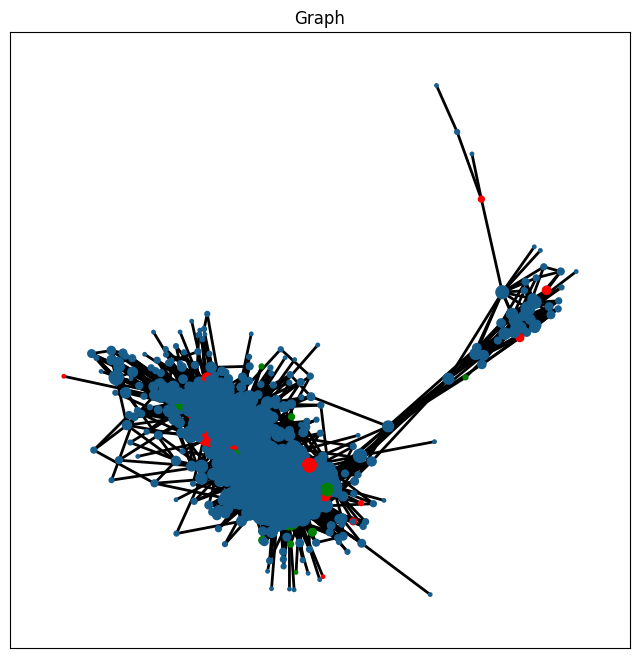

In [11]:
draw_graph(subgraph_sparse, source=subgraph_source, target=subgraph_target) 

In [12]:

def generate_RWR_walks(G, root, num_walks=10, walk_length=5, restart_prob=0.5, view_nodes=None): 
    walks=[]
    for _ in range(num_walks):
        walk = [root]
        current_node = root
        for _ in range(walk_length - 1):
            neighbors = list(G.neighbors(current_node))
            
            if view_nodes is not None: 
                neighbors = [n for n in neighbors if n in view_nodes]
            if len(neighbors) == 0:
                break
            if random.random() < restart_prob: 
                walk.append(root)
            else:
                walk.append(random.choice(neighbors))
            next_node = random.choice(neighbors)
            
        walks.append(walk)
    return walks

def get_RWR_pagerank_scores(
    G,
    root,
    restart_prob=0.15,
    view_nodes=None,
    weight=None,
    tol=1e-6,
    max_iter=100
):
    """
    Random Walk with Restart using PageRank.

    Parameters
    ----------
    G : networkx.Graph
    root : node
        Restart node
    restart_prob : float
        Alpha (restart probability)
    view_nodes : set or None
        Optional constraint: restrict graph to these nodes
    weight : str or None
        Edge weight attribute
    tol : float
        Convergence tolerance
    max_iter : int
        Max iterations

    Returns
    -------
    dict
        Node -> RWR stationary probability
    """
    if view_nodes is not None:
        G = G.subgraph(view_nodes)

    if root not in G:
        raise ValueError("Root node not in graph or view")

    # Personalization vector (restart distribution)
    personalization = {n: 0.0 for n in G.nodes()}
    personalization[root] = 1.0

    pr = nx.pagerank(
        G,
        alpha=1 - restart_prob,
        personalization=personalization,
        weight=weight,
        tol=tol,
        max_iter=max_iter
    )

    return pr

def sample_rwr_walks_from_scores(
    rwr_scores,
    num_walks=10,
    walk_length=40,
    seed=None
):
    """
    Generate pseudo-walks by sampling from RWR stationary distribution.

    Parameters
    ----------
    rwr_scores : dict
        Node -> probability
    num_walks : int
    walk_length : int
    seed : int or None

    Returns
    -------
    List[List[node]]
    """
    rng = random.Random(seed)

    nodes = list(rwr_scores.keys())
    probs = [rwr_scores[n] for n in nodes]

    walks = []
    for _ in range(num_walks):
        walk = rng.choices(nodes, weights=probs, k=walk_length)
        walks.append(walk)
    
    return walks

def generate_RWR_pagerank_walks(G, root, view_nodes=None, num_walks=10, walk_length=6, restart_prob=0.5):
    rwr_scores = get_RWR_pagerank_scores(
        G,
        root,
        restart_prob=restart_prob,
        view_nodes=view_nodes
    )
    walks = sample_rwr_walks_from_scores(
        rwr_scores,
        num_walks=num_walks,
        walk_length=walk_length
    )
    
    return walks

def generate_ctqw_hiperwalk_scores(G, root, view_nodes=None, steps: int=20, time: float | None=None, gamma: float | None=None):
    """
    Return node probabilities from Hiperwalk continuous-time quantum walk (CTQW)
    Args:
        G (_type_): _description_
        root (_type_): _description_
        view_nodes (_type_, optional): _description_. Defaults to None.
        steps (int, optional): _description_. Defaults to 20.
        time (float | None, optional): _description_. Defaults to None.
        gamma (float | None, optional): _description_. Defaults to None.
    """
    if view_nodes is not None: 
        G = G.subgraph(view_nodes)
    if root not in G: 
        raise ValueError("Root node not in graph or view")
    
    nodes = list(G.nodes())
    node2i = {n:i for i,n in enumerate(nodes)}
    i2node = {i:n for n,i in node2i.items()}
    G_int = nx.relabel_nodes(G,node2i, copy=True)
    
    #build hiperwalk graph + ctqw 
    hg = hpw.Graph(G_int)
    qw = hpw.ContinuousTime(graph=hg) 
    
    if gamma is not None:
        qw.set_gamma(gamma)
    if time is not None:
        qw.set_time(time)
    
    root_i = node2i[root]
    state0 = qw.ket(root_i)
    
    #simulate to obtain final state at steps
    final_state = qw.simulate(range=(steps, steps+1), state=state0)
    
    #convert to node probability
    probs = qw.probability_distribution(final_state)
    probs = np.asarray(probs)[0]
    
    #map to original ids
    scores = {i2node[i]: float(probs[i]) for i in range(len(probs))}
    
    return scores

def generate_ctqw_hiperwalk_walks(G, root, view_nodes=None, num_walks: int = 10, 
                                walk_length: int = 6, steps: int=20, time: float | None=None, gamma: float | None=None, seed: int | None=None):
    
    scores = generate_ctqw_hiperwalk_scores(G, root=root, view_nodes=view_nodes, 
                                            steps=steps, time=time, gamma=gamma)
    walks = sample_rwr_walks_from_scores(scores, num_walks=num_walks, walk_length=walk_length, seed=seed)
    return walks 

def get_coined_hiperwalk_scores(G, root, view_nodes=None, steps: int=25, coin: str="grover"): 
    """
    Return node probabilities from Hiperwalk coined quantum walk (CQW)
    Args:
        G (_type_): _description_
        root (_type_): _description_
        view_nodes (_type_, optional): _description_. Defaults to None.
        steps (int, optional): _description_. Defaults to 25.
        coin (str, optional): _description_. Defaults to "grover".
    """ 
    
    if view_nodes is not None: 
        G = G.subgraph(view_nodes)
    if root not in G: 
        raise ValueError("Root node not in graph or view")
    
    nodes = list(G.nodes())
    node2i = {n:i for i,n in enumerate(nodes)}
    i2node = {i:n for n,i in node2i.items()}
    G_int = nx.relabel_nodes(G,node2i, copy=True)
    
    #build hiperwalk graph + dtqw 
    hg = hpw.Graph(G_int)
    qw = hpw.Coined(graph=hg, coin=coin) 
    
    root_i = node2i[root]
    neighbors = list(G_int.neighbors(root_i))
    
    if len(neighbors) == 0: 
        raise ValueError("Root node has no neighbors in the graph or view")
    
    state0 = qw.ket(root_i) 
    
    final_state = qw.simulate(range=(steps, steps+1), state=state0)
        
    #convert to node probability
    probs = qw.probability_distribution(final_state)
    probs = np.asarray(probs)[0]
    # 9) Map back to original node labels
    scores = {i2node[i]: float(probs[i]) for i in range(len(probs))}
    
    return scores

def generate_coined_hiperwalk_walks(G, root, view_nodes=None, num_walks: int = 10, 
                                walk_length: int = 6, steps: int=25, coin: str="grover", seed: int | None=None):
    scores = get_coined_hiperwalk_scores(G, root=root, view_nodes=view_nodes, 
                                        steps=steps, coin=coin)
    walks = sample_rwr_walks_from_scores(scores, num_walks=num_walks, walk_length=walk_length, seed=seed)
    return walks

def generate_views(G,root, num_views=5, constrained=False, max_edges=40, max_degree=3, max_nodes=15, radius=4, seed=None): 
    """
    Generate multiple views of the graph G centered around the root node.
    """
    
    rng = random.Random(seed)
    views = [] 
    
    if not constrained: 
        #unconstrained view
        ego_nodes = list(nx.single_source_shortest_path_length(G, root, cutoff=radius).keys())
        for _ in range(num_views):
            #random subsample
            k = min(len(ego_nodes), max_nodes)
            view = set(rng.sample(ego_nodes, k))
            views.append(view)
            
        return views
    
    neighbors = list(G.neighbors(root))
    
    for _ in range(num_views):
        view_nodes = {root}
        view_edges = set() 
        
        #randomize expansion order 
        frontier = neighbors[:]
        rng.shuffle(frontier)
        
        while frontier: 
            candidate_node = frontier.pop()
            if candidate_node in view_nodes:
                continue 
            else:
                new_nodes = view_nodes | {candidate_node}
                induced = G.subgraph(new_nodes)
                
                if induced.number_of_edges() > max_edges:
                    continue
                if max(dict(induced.degree()).values()) > max_degree:
                    continue 
                
                #accept 
                view_nodes.add(candidate_node)
                
                #add new neighbors to frontier
                for neighbor in G.neighbors(candidate_node):
                    if neighbor not in view_nodes:
                        frontier.append(neighbor)
                        
                if induced.number_of_edges() >= max_edges or len(view_nodes) >= max_nodes: 
                    break
                
        views.append(view_nodes)
    return views 

def define_corpus(view_walks):
    corpus = []
    
    for view in view_walks: 
        corpus.extend(view)

    return corpus

def compile_corpus(node_corpus):
    all_corpus = []
    for _, walks in node_corpus.items():
        for walk in walks:
            all_corpus.append(walk)
    return all_corpus

def corpus_to_embedding(sentence, 
                        nodes: list, 
                        vector_size=64, 
                        window=5, 
                        sg=1, 
                        negative=10, 
                        min_count=0, 
                        workers=8, 
                        epochs=100
                    ): 
    
    for v in nodes:
        sentence.append([v])
        
    model = Word2Vec(
        sentences=sentence, 
        vector_size=vector_size, 
        window=window, 
        sg=sg, 
        negative=negative, 
        min_count=min_count, 
        workers=workers,
        epochs=epochs
    )

    Z = np.zeros((len(nodes), 64))
    for i,v in enumerate(nodes):
        Z[i] = model.wv[v]
        
    return Z

In [13]:
num_walks = 10
walk_length = 6
restart_prob = 0.15
subgraph = subgraph_sparse.copy()
#root = list(subgraph_source)[random.choice(range(len(subgraph_source)))]
#print(root)
rwr_node_corpus = {}
ctqw_node_corpus = {}
dtqw_node_corpus = {}

for root in subgraph.nodes: 
    # print("Root:", root)
    # print("Root degree:", subgraph.degree(root))
    # print("View nodes:", len(view_g.nodes()))
    # print("Edges in view graph:", view_g.number_of_edges())

    # # Check connectivity
    # if root in subgraph:
    #     print("Root component size:",
    #         len(nx.node_connected_component(subgraph, root)))
    views = generate_views(subgraph, root, constrained=True, max_nodes=40, seed=42)
    view_rwr_walks = []
    view_ctqw_walks = []
    view_dtqw_walks = []
    for view in views: 
        view_g = subgraph.subgraph(view)
        # print(get_stats(view_g))
        # draw_graph(view_g)
        #walks1 = generate_RWR_walks(subgraph, root, view_nodes=list(view_g.nodes()), restart_prob=restart_prob)
        rwr_walks = generate_RWR_pagerank_walks(subgraph, root, view_nodes=list(view_g.nodes()), restart_prob=restart_prob)
        view_rwr_walks.append(rwr_walks)
        
        ctqw_walks = generate_ctqw_hiperwalk_walks(subgraph, root, view_nodes=list(view_g.nodes()), 
                                                steps=20, seed=42)
        view_ctqw_walks.append(ctqw_walks) 

        dtqw_walks = generate_coined_hiperwalk_walks(subgraph, root, view_nodes=list(view_g.nodes()), 
                                                steps=25, coin="grover", seed=42)
        view_dtqw_walks.append(dtqw_walks)
        
    rwr_node_corpus[root] = define_corpus(view_rwr_walks)
    ctqw_node_corpus[root] = define_corpus(view_ctqw_walks)
    dtqw_node_corpus[root] = define_corpus(view_dtqw_walks)
    
all_rwr_corpus = compile_corpus(rwr_node_corpus)
all_ctqw_corpus = compile_corpus(ctqw_node_corpus)
all_dtqw_corpus = compile_corpus(dtqw_node_corpus)
print(f"Generated walks for {len(subgraph.nodes())} nodes")


Generated walks for 600 nodes


In [14]:
Z_rwr = corpus_to_embedding(all_rwr_corpus, nodes=list(subgraph.nodes))
Z_ctqw = corpus_to_embedding(all_ctqw_corpus, nodes=list(subgraph.nodes()))
Z_dtqw = corpus_to_embedding(all_dtqw_corpus, nodes=list(subgraph.nodes()))

In [15]:
# Node2Vec Model Initialization
node2vec = Node2Vec(subgraph, dimensions=64, walk_length=walk_length, num_walks=num_walks, p=1, q=0.5, workers=8)

# Node2Vec Embedding Generation
model = node2vec.fit(window=5, min_count=1, batch_words=4)

# Accessing Node2vec Embeddings
n2v_embeddings = model.wv # Word vectors (embeddings)
Z_n2v = n2v_embeddings.vectors
print(Z_n2v.shape) # Shape of the embedding matrix

Computing transition probabilities:   0%|          | 0/600 [00:00<?, ?it/s]

Generating walks (CPU: 2): 100%|██████████| 2/2 [00:00<00:00, 69.79it/s]


(600, 64)


In [16]:
def normalize(embedding, eps=1e-8): 
    mean = embedding.mean(axis=0, keepdims=True)
    std = embedding.std(axis=0, keepdims=True) + eps
    return (embedding - mean) / std

def procrustes_residual(Z1,Z2): 
    scaledZ1 = Z1 - Z1.mean(0)
    scaledZ2 = Z2 - Z2.mean(0)
    R, _ = orthogonal_procrustes(scaledZ1, scaledZ2)
    residual = np.linalg.norm(scaledZ1 - scaledZ2@R)/np.linalg.norm(scaledZ1)
    
    return residual

def cca_correlation(Z1, Z2, n_components=10):
    scaledZ1 = normalize(Z1)
    scaledZ2 = normalize(Z2)
    cca = CCA(n_components=n_components)
    Z1_c, Z2_c = cca.fit_transform(scaledZ1, scaledZ2)
    corrs = [np.corrcoef(Z1_c[:,i], Z2_c[:,i])[0,1] for i in range(n_components)]
    return np.mean(corrs)

def rsa_corr(Z1, Z2):
    D1 = pdist(Z1)
    D2 = pdist(Z2)
    rsa_corr = spearmanr(D1, D2).correlation
    return rsa_corr

def knn_sets(Z, k=10): 
    neighbors = NearestNeighbors(n_neighbors=k+1).fit(Z)
    idx = neighbors.kneighbors(Z, return_distance=False)
    return [set(row[1:]) for row in idx]

def knn_overlap(Z1, Z2, k=10):
    K1 = knn_sets(Z1, k)
    K2 = knn_sets(Z2, k)
    overlap = np.mean([len(K1[i] & K2[i])/k for i in range(len(K1))])
    return overlap

def effective_rank(s):
    p = s / s.sum()
    return np.exp(-np.sum(p * np.log(p + 1e-12)))

def plot_singular_values(singular_values, label='concatenate', filename=None):
    plt.figure()
    plt.plot(list(range(1, len(singular_values)+1)), [np.log(x) for x in singular_values], marker='o', color='blue', label=label)
    plt.xlabel('Singular Value Index')
    plt.ylabel('Log(Singular Value)')
    plt.legend()
    plt.show()
    if filename is not None:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()
    
def spectral_info(embeddings, labels, plot_flag=False):
    
    singular_values = []
    ks = []
    for z in embeddings:
        scaledZ = normalize(z)
        s = np.linalg.svd(scaledZ, compute_uv=False)
        singular_values.append(s)
        ks.append(len(s))
    k = min(ks)
    sk = []
    for s in singular_values:
        sk.append(s[:k])

    if plot_flag:
        fig = plt.figure()
        for i,s in enumerate(sk):
            plt.plot(np.log(s), label=labels[i])
        plt.xlabel('singular value index i')
        plt.ylabel('log($s_i$)')
        plt.legend()
        plt.show()
        fig.savefig('log_spectrum.png', 
                    dpi=300, 
                    bbox_inches='tight')
        
        fig = plt.figure()
        for i,s in enumerate(sk):
            plt.loglog(s, label=labels[i])
        plt.xlabel('singular value index i')
        plt.ylabel('loglog($s_i$)')
        plt.legend()
        plt.show()
        fig.savefig('loglog_spectrum.png', 
                    dpi=300, 
                    bbox_inches='tight')
        skn = [] 
        for s in sk:
            skn.append(s / np.sum(s))
        fig = plt.figure()
        for i,s in enumerate(skn):
            plt.plot(np.log(s), label=labels[i])
        plt.xlabel('singular value index i')
        plt.ylabel('log(normalized $s_i$)')
        plt.legend()
        plt.show()
        fig.savefig('log_normalized_spectrum.png', 
                    dpi=300, 
                    bbox_inches='tight')
    effective_ranks = {} 
    for i,label in enumerate(labels): 
        effective_ranks[label] = effective_rank(sk[i]) 
    
    return effective_ranks  


### Fuse embeddings for SQuIRL

In [17]:

def fuse_embeddings(embedding_list, method='concatenate', k=None):
    """
    Fuse multiple embeddings

    Args:
        embedding_list (_type_): _description_
        method (str, optional): _description_. Defaults to 'concatenate'.
    """
    norm_embeddings = []
    for z in embedding_list:
            norm_embeddings.append(normalize(z))
            
    if k is None: 
        ks = [z.shape[1] for z in embedding_list]
        k = min(ks)
    
    if method == 'concatenate': 
        fused_embedding = np.concatenate(norm_embeddings, axis=1)
        ## svd to factor fused embeddings
        U, S, _ = svd(fused_embedding, full_matrices=False)
        shared_embedding = U[:,:k] @ np.diag(S[:k]) #rank k
        return shared_embedding, S[:k]
    
    elif method == 'projection':
        projections = []
        for z in norm_embeddings:
            U, S, _ = svd(z, full_matrices=False)
            Uk = U[:,:k]
            projections.append(Uk @ Uk.T)
            
        fused_projection = sum(projections) / len(projections)
        #get top k eigenvectors
        eigval, eigvec = np.linalg.eigh(fused_projection)
        idx = np.argsort(eigval)[::-1]
        eigval = eigval[idx]
        eigvec = eigvec[:,idx]
        shared_embedding = eigvec[:,:k]
        return shared_embedding, eigval[:k]


def plot_concat_singular_values(singular_values, label='Concat–PCA', filename=None):
    plt.figure()
    x = np.arange(1, len(singular_values) + 1)
    plt.plot(x, np.log(singular_values), marker='o', label=label)

    plt.xlabel('Component index')
    plt.ylabel('log(singular value)')
    plt.legend()
    plt.tight_layout()

    if filename is not None:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


def plot_consensus_eigenvalues(eigvals, n_views=3, filename=None):
    plt.figure()
    x = np.arange(1, len(eigvals) + 1)
    plt.plot(x, eigvals, marker='o', label='Consensus eigenvalues')

    # reference lines
    plt.axhline(1.0, linestyle='--', color='gray', label='all views')
    plt.axhline(2/n_views, linestyle='--', color='orange', label='2 views')
    plt.axhline(1/n_views, linestyle='--', color='red', label='1 view')

    plt.xlabel('Component index')
    plt.ylabel('Eigenvalue')
    plt.legend()
    plt.tight_layout()

    if filename is not None:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
def plot_shared_private_energy(embedding_list, U_shared, view_names=None, filename=None):
    if view_names is None:
        view_names = [f'View {i+1}' for i in range(len(norm_embeddings))]

    shared_fracs = []
    private_fracs = []

    norm_embeddings = []
    for z in embedding_list:
            norm_embeddings.append(normalize(z))
    
    for Z in norm_embeddings:
        Z_shared = U_shared @ (U_shared.T @ Z)
        Z_private = Z - Z_shared

        total_energy = np.linalg.norm(Z, 'fro')**2
        shared_energy = np.linalg.norm(Z_shared, 'fro')**2
        private_energy = np.linalg.norm(Z_private, 'fro')**2

        shared_fracs.append(shared_energy / total_energy)
        private_fracs.append(private_energy / total_energy)

    x = np.arange(len(norm_embeddings))

    plt.figure()
    plt.bar(x, shared_fracs, label='Shared', color='tab:blue')
    plt.bar(x, private_fracs, bottom=shared_fracs, label='Private', color='tab:orange')

    plt.xticks(x, view_names)
    plt.ylabel('Fraction of energy')
    plt.ylim(0, 1.05)
    plt.legend()
    plt.tight_layout()

    if filename is not None:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    
    plt.close()


In [18]:
concatenated_embeddings = [Z_rwr, Z_ctqw, Z_dtqw]
concat_fuse_embedding, concat_singular_values = fuse_embeddings(
                                                            concatenated_embeddings,
                                                            method='concatenate'
                                                            )
proj_fuse_embedding, proj_singular_values = fuse_embeddings(
                                                            concatenated_embeddings,
                                                            method='projection'
                                                            )

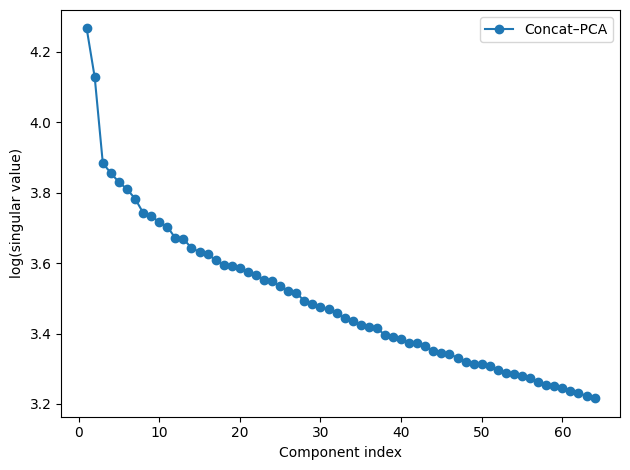

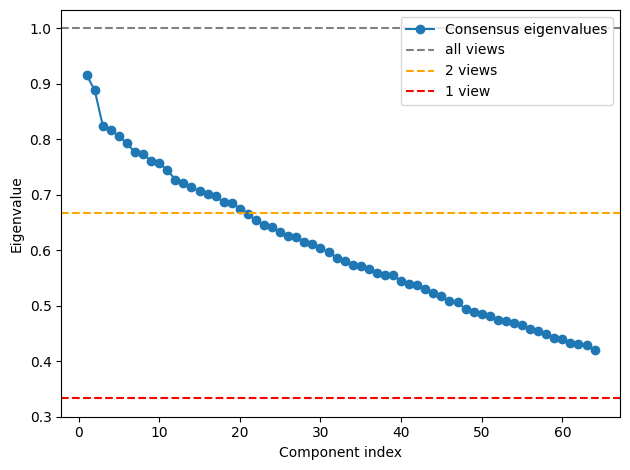

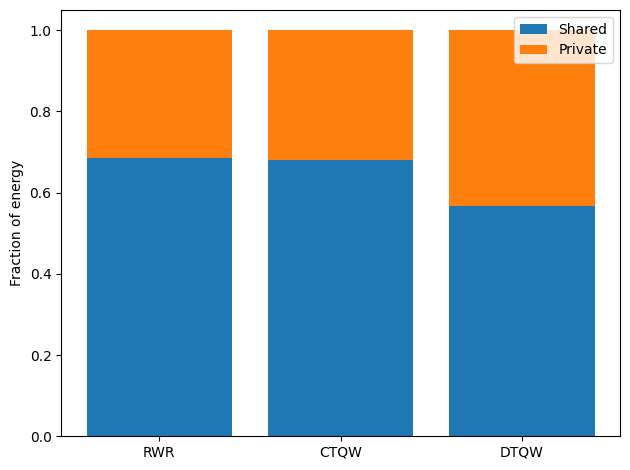

In [19]:
plot_concat_singular_values(concat_singular_values)

plot_consensus_eigenvalues(proj_singular_values)

plot_shared_private_energy(concatenated_embeddings, 
                        U_shared=proj_fuse_embedding,
                        view_names=['RWR', 'CTQW', 'DTQW'])

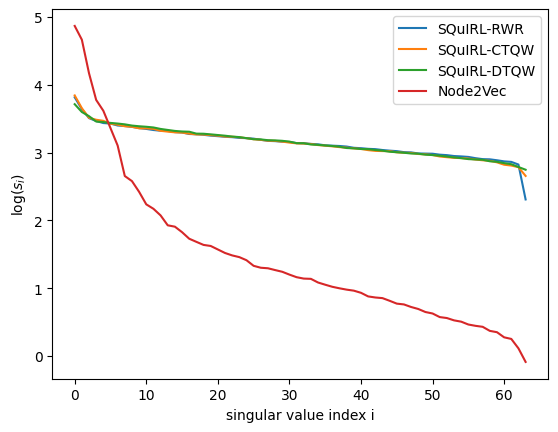

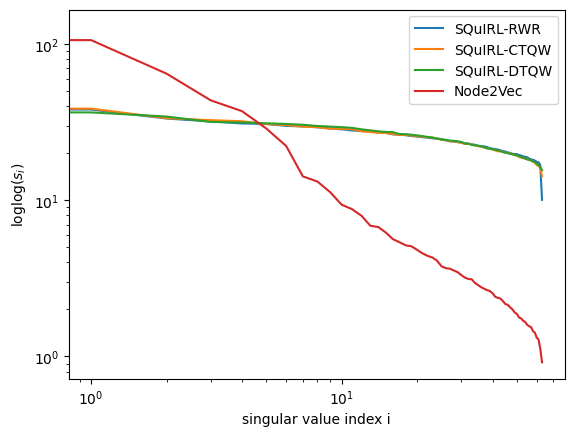

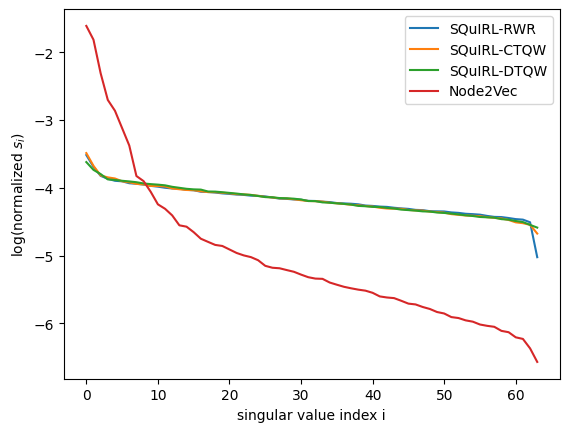

{'SQuIRL-RWR': 62.436728918912124,
 'SQuIRL-CTQW': 62.37633603211567,
 'SQuIRL-DTQW': 62.54886900343726,
 'Node2Vec': 22.020311}

In [20]:
embeddings = [Z_rwr, Z_ctqw, Z_dtqw, Z_n2v]
              #concat_fuse_embedding, proj_fuse_embedding, Z_n2v]
labels = ['SQuIRL-RWR', 'SQuIRL-CTQW', 'SQuIRL-DTQW', 'Node2Vec']
        #'SQuIRL-Fuse-concat', 'SQuIRL-Fuse-proj','Node2Vec']

spectral_info(embeddings, labels, plot_flag=True)

In [21]:
combos = list(itertools.combinations(range(len(embeddings)), 2))
combo_metrics_dict = {}
for combo in combos: 
    combo_name = f"{labels[combo[0]]}_vs_{labels[combo[1]]}"
    Z1 = embeddings[combo[0]]
    Z2 = embeddings[combo[1]]
    residual = procrustes_residual(Z1, Z2)
    cca_corr = cca_correlation(Z1, Z2, n_components=10)
    rsa_correlation = rsa_corr(Z1, Z2)
    knn_overlap_score = knn_overlap(Z1, Z2, k=10)
    
    combo_metrics_dict[combo_name] = {
        "Procrustes Residual": residual,
        "CCA Correlation": cca_corr,
        "RSA Correlation": rsa_correlation,
        "KNN Overlap": knn_overlap_score
    }

In [22]:
pd.DataFrame.from_dict(combo_metrics_dict, orient='index')

,Procrustes Residual,CCA Correlation,RSA Correlation,KNN Overlap
SQuIRL-RWR_vs_SQuIRL-CTQW,1.404078,0.839244,0.583119,0.354500
SQuIRL-RWR_vs_SQuIRL-DTQW,1.347786,0.729727,0.429041,0.227333
SQuIRL-RWR_vs_Node2Vec,1.035622,0.576006,0.082600,0.023500
SQuIRL-CTQW_vs_SQuIRL-DTQW,1.365970,0.719479,0.522940,0.182333
SQuIRL-CTQW_vs_Node2Vec,1.037711,0.557898,0.068018,0.019500
SQuIRL-DTQW_vs_Node2Vec,1.046407,0.551992,0.064445,0.017667


### Downstream tasks
#### Ranking targets to seeds 

In [23]:
def l2_normalize(X, axis=1, eps=1e-12):
    norm = np.linalg.norm(X, axis=axis, keepdims=True)
    return X / (norm + eps)

def seed_centroid_scores(Z, seed_indices):
    """
    Generates centroid scores based on seed node embeddings. 
    
    Z: (n,e) embedding matrix aligned with subgraph nodes 
    seed_indices: list of indices corresponding to seed nodes in Z
    
    Returns
    -------
    scores: cosine similarity to seed centroid 
    
    """
    Z_norm = l2_normalize(Z, axis=1)
    Z_seed = Z_norm[seed_indices]
    centroid = Z_seed.mean(axis=0)
    #normalize centroid 
    centroid /= max(np.linalg.norm(centroid), 1e-12)
    
    #cosine similarity to centroid 
    scores = Z_norm @ centroid
    
    return scores 

def max_seed_cosine_scores(Z, seed_indices, block=4096):
    """
    Returns scores[v] = max_{s in seeds} cosine(z_v, z_s)
    Works for any embedding Z.

    block: compute in chunks to reduce memory if needed.
    """
    Z = l2_normalize(Z)
    S = Z[list(seed_indices)]  # (m, e)

    scores = np.full(Z.shape[0], -np.inf, dtype=float)

    # chunked matmul: (block × e) @ (e × m) -> (block × m)
    for start in range(0, Z.shape[0], block):
        end = min(start + block, Z.shape[0])
        sims = Z[start:end] @ S.T
        scores[start:end] = sims.max(axis=1)

    return scores

nodes = list(subgraph.nodes())
node2i = {v: i for i, v in enumerate(nodes)}
i2node = {i: v for v, i in node2i.items()}


In [24]:
print(subgraph_target)
print([node2i[x] for x in subgraph_target])
print([i2node[x] for x in [node2i[y] for y in subgraph_target]])

{'1665', '3329', '9978', '3661', '79137', '26058', '91526', '1983', '23383', '23293', '23019', '80335', '119032', '5481', '5717', '81929', '54815', '2968', '3921'}
[441, 517, 554, 4, 563, 8, 449, 91, 231, 57, 237, 189, 214, 461, 30, 310, 220, 118, 474]
['1665', '3329', '9978', '3661', '79137', '26058', '91526', '1983', '23383', '23293', '23019', '80335', '119032', '5481', '5717', '81929', '54815', '2968', '3921']


In [25]:
seed_indices = [i for i, node in enumerate(subgraph.nodes) if node in subgraph_source]
rwr_scores = seed_centroid_scores(Z_rwr, seed_indices)
ctqw_scores = seed_centroid_scores(Z_ctqw, seed_indices)
dtqw_scores = seed_centroid_scores(Z_dtqw, seed_indices)
n2v_scores = seed_centroid_scores(Z_n2v, seed_indices)

rwr_max_scores = max_seed_cosine_scores(Z_rwr, seed_indices)
ctqw_max_scores = max_seed_cosine_scores(Z_ctqw, seed_indices)
dtqw_max_scores = max_seed_cosine_scores(Z_dtqw, seed_indices)
n2v_max_scores = max_seed_cosine_scores(Z_n2v, seed_indices)

In [26]:
def recall_at_k(scores, target_nodes, k):
    target_indices = {node2i[v] for v in target_nodes}
    candidate_indices = [
        node2i[v] for v in subgraph.nodes()
        if v not in subgraph_source
    ]
    # sort candidates by score (descending)
    ranked_indices = sorted(
        candidate_indices,
        key=lambda i: scores[i],
        reverse=True
    )

    top_k = ranked_indices[:k]
    hits = sum(i in target_indices for i in top_k)

    return hits / len(target_indices)

methods = ['SQuIRL-RWR', 'SQuIRL-CTQW', 'SQuIRL-DTQW', 'Node2Vec']
K = [30, 60, 90, 120]
recall_dict = {
    outer_key: {inner_key: None for inner_key in K}
    for outer_key in methods
}
for method in methods:
    for k in K: 
        if 'RWR' in method:
            recall_dict[method][k] = recall_at_k(rwr_max_scores, target_nodes=subgraph_target, k=k)
        elif 'CTQW' in method:
            recall_dict[method][k] = recall_at_k(ctqw_max_scores, target_nodes=subgraph_target, k=k)
        elif 'DTQW' in method:
            recall_dict[method][k] = recall_at_k(dtqw_max_scores, target_nodes=subgraph_target, k=k)
        elif 'Node2Vec' in method:
            recall_dict[method][k] = recall_at_k(n2v_max_scores, target_nodes=subgraph_target, k=k)

recall_dict

{'SQuIRL-RWR': {30: 0.05263157894736842,
  60: 0.05263157894736842,
  90: 0.15789473684210525,
  120: 0.21052631578947367},
 'SQuIRL-CTQW': {30: 0.05263157894736842,
  60: 0.15789473684210525,
  90: 0.15789473684210525,
  120: 0.15789473684210525},
 'SQuIRL-DTQW': {30: 0.05263157894736842,
  60: 0.05263157894736842,
  90: 0.05263157894736842,
  120: 0.05263157894736842},
 'Node2Vec': {30: 0.0, 60: 0.0, 90: 0.0, 120: 0.05263157894736842}}

In [27]:
pd.DataFrame(recall_dict)


,SQuIRL-RWR,SQuIRL-CTQW,SQuIRL-DTQW,Node2Vec
30,0.052632,0.052632,0.052632,0.000000
60,0.052632,0.157895,0.052632,0.000000
90,0.157895,0.157895,0.052632,0.000000
120,0.210526,0.157895,0.052632,0.052632


In [28]:
import numpy as np
import random
import networkx as nx


class SeedTargetEvaluator:
    """
    Evaluates seed→target prioritization on a subgraph.
    """

    def __init__(
        self,
        subgraph,
        seeds,
        targets,
        nodes=None
    ):
        """
        Parameters
        ----------
        subgraph : nx.Graph
        seeds : set
            Seed node labels
        targets : set
            Target node labels
        nodes : list or None
            Fixed node ordering; if None, uses subgraph.nodes()
        """

        self.subgraph = subgraph
        self.nodes = list(nodes) if nodes is not None else list(subgraph.nodes())

        self.node2i = {v: i for i, v in enumerate(self.nodes)}
        self.i2node = {i: v for v, i in self.node2i.items()}

        # sets in node-label space
        self.seeds = set(seeds) & set(self.nodes)
        self.targets = set(targets) & set(self.nodes)

        # index space
        self.seed_indices = {self.node2i[v] for v in self.seeds}
        self.target_indices = {self.node2i[v] for v in self.targets}

        self.candidate_indices = [
            self.node2i[v] for v in self.nodes if v not in self.seeds
        ]
        self.candidate_nodes = [self.i2node[i] for i in self.candidate_indices]

        # graph properties
        self.deg = dict(subgraph.degree())
        self.dist = self._compute_min_distance_to_seeds()

    # ---------------------------
    # Internal helpers
    # ---------------------------

    def _compute_min_distance_to_seeds(self):
        dist = {}
        for v in self.nodes:
            dist[v] = min(
                nx.shortest_path_length(self.subgraph, v, s)
                for s in self.seeds
            )
        return dist

    def _rank_indices(self, scores):
        return sorted(
            self.candidate_indices,
            key=lambda i: scores[i],
            reverse=True
        )

    # ---------------------------
    # Metrics
    # ---------------------------

    def recall_at_k(self, scores, target_indices, k):
        ranked = self._rank_indices(scores)
        top_k = ranked[:k]
        hits = sum(i in target_indices for i in top_k)
        return hits / max(len(target_indices), 1)
    
    def precision_at_k(self, scores, target_indices, k):
        ranked = self._rank_indices(scores)
        top_k = ranked[:k]
        hits = sum(i in target_indices for i in top_k)
        return hits / k


    # ---------------------------
    # Controls
    # ---------------------------

    def degree_matched_targets(self, tolerance=0.1, random_state=None):
        if random_state is not None:
            random.seed(random_state)

        matched = set()
        candidates = set(self.candidate_nodes) - self.targets

        for t in self.targets:
            dt = self.deg[t]
            low = int((1 - tolerance) * dt)
            high = int((1 + tolerance) * dt)

            pool = [
                v for v in candidates
                if low <= self.deg[v] <= high
            ]
            if pool:
                matched.add(random.choice(pool))

        return matched

    def distance_matched_targets(self, random_state=None):
        if random_state is not None:
            random.seed(random_state)

        matched = set()
        candidates = set(self.candidate_nodes) - self.targets

        bins = defaultdict(list)
        for v in candidates:
            bins[self.dist[v]].append(v)

        for t in self.targets:
            d = self.dist[t]
            if bins[d]:
                matched.add(random.choice(bins[d]))

        return matched

    # ---------------------------
    # Full evaluation
    # ---------------------------

    def evaluate(
        self,
        scores,
        k_values=(20, 50, 100),
        n_repeats=20,
        deg_tol=0.1
    ):
        """
        Returns recall@k and precision@k for:
        - true targets
        - degree-matched random targets
        - distance-matched random targets
        """

        results = {}

        # --------------------
        # True targets
        # --------------------
        results["true"] = {
            "recall": {
                k: self.recall_at_k(scores, self.target_indices, k)
                for k in k_values
            },
            "precision": {
                k: self.precision_at_k(scores, self.target_indices, k)
                for k in k_values
            }
        }

        # --------------------
        # Degree-matched controls
        # --------------------
        deg_recalls = {k: [] for k in k_values}
        deg_precisions = {k: [] for k in k_values}

        for r in range(n_repeats):
            dm = self.degree_matched_targets(
                tolerance=deg_tol,
                random_state=r
            )
            dm_idx = {self.node2i[v] for v in dm}

            for k in k_values:
                deg_recalls[k].append(
                    self.recall_at_k(scores, dm_idx, k)
                )
                deg_precisions[k].append(
                    self.precision_at_k(scores, dm_idx, k)
                )

        results["degree_matched"] = {
            "recall": {
                k: (np.mean(deg_recalls[k]), np.std(deg_recalls[k]))
                for k in k_values
            },
            "precision": {
                k: (np.mean(deg_precisions[k]), np.std(deg_precisions[k]))
                for k in k_values
            }
        }

        # --------------------
        # Distance-matched controls
        # --------------------
        dist_recalls = {k: [] for k in k_values}
        dist_precisions = {k: [] for k in k_values}

        for r in range(n_repeats):
            dm = self.distance_matched_targets(random_state=r)
            dm_idx = {self.node2i[v] for v in dm}

            for k in k_values:
                dist_recalls[k].append(
                    self.recall_at_k(scores, dm_idx, k)
                )
                dist_precisions[k].append(
                    self.precision_at_k(scores, dm_idx, k)
                )

        results["distance_matched"] = {
            "recall": {
                k: (np.mean(dist_recalls[k]), np.std(dist_recalls[k]))
                for k in k_values
            },
            "precision": {
                k: (np.mean(dist_precisions[k]), np.std(dist_precisions[k]))
                for k in k_values
            }
        }

        return results



In [29]:
st_eval = SeedTargetEvaluator(subgraph=subgraph, 
                            seeds=subgraph_source,
                            targets=subgraph_target)
methods = {
    "RWR": rwr_max_scores,
    "CTQW": ctqw_max_scores,
    "DTQW": dtqw_max_scores,
    "Node2Vec": n2v_max_scores
}

k_values = (30, 60, 90, 120)

all_results = {}

for method, scores in methods.items():
    all_results[method] = st_eval.evaluate(
        scores=scores,
        k_values=k_values,
        n_repeats=30,
        deg_tol=0.1
    )

In [30]:

rows = []

for method, res in all_results.items():
    for control in ["true", "degree_matched", "distance_matched"]:
        for metric in ["recall", "precision"]:
            for k in k_values:
                if control == "true":
                    value = res[control][metric][k]
                    rows.append({
                        "method": method,
                        "control": control,
                        "metric": metric,
                        "k": k,
                        "mean": value,
                        "std": 0.0
                    })
                else:
                    mean, std = res[control][metric][k]
                    rows.append({
                        "method": method,
                        "control": control,
                        "metric": metric,
                        "k": k,
                        "mean": mean,
                        "std": std
                    })

df = pd.DataFrame(rows)


In [31]:
df

,method,control,metric,k,mean,std
0,RWR,true,recall,30,0.052632,0.000000
1,RWR,true,recall,60,0.052632,0.000000
2,RWR,true,recall,90,0.157895,0.000000
3,RWR,true,recall,120,0.210526,0.000000
4,RWR,true,precision,30,0.033333,0.000000
...,...,...,...,...,...,...
91,Node2Vec,distance_matched,recall,120,0.210741,0.116481
92,Node2Vec,distance_matched,precision,30,0.023333,0.026034
93,Node2Vec,distance_matched,precision,60,0.019444,0.019285
94,Node2Vec,distance_matched,precision,90,0.017778,0.013333


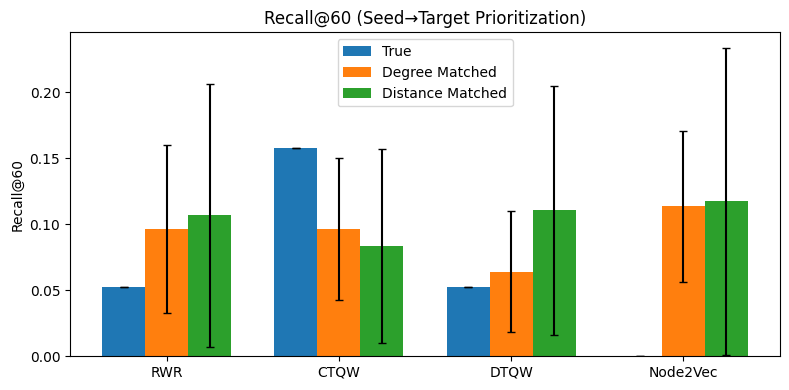

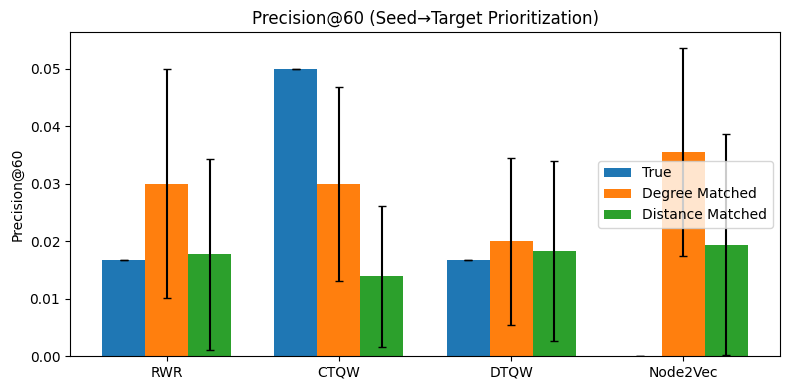

In [32]:

def plot_metric(df, metric, k):
    subset = df[(df.metric == metric) & (df.k == k)]

    fig, ax = plt.subplots(figsize=(8, 4))

    x = range(len(methods))
    width = 0.25

    for i, control in enumerate(["true", "degree_matched", "distance_matched"]):
        vals = subset[subset.control == control]
        ax.bar(
            [p + i * width for p in x],
            vals["mean"],
            width,
            yerr=vals["std"],
            label=control.replace("_", " ").title(),
            capsize=3
        )

    ax.set_xticks([p + width for p in x])
    ax.set_xticklabels(methods.keys())
    ax.set_ylabel(f"{metric.title()}@{k}")
    ax.set_title(f"{metric.title()}@{k} (Seed→Target Prioritization)")
    ax.legend()
    plt.tight_layout()
    plt.show()

plot_metric(df, metric="recall", k=60)
plot_metric(df, metric="precision", k=60)


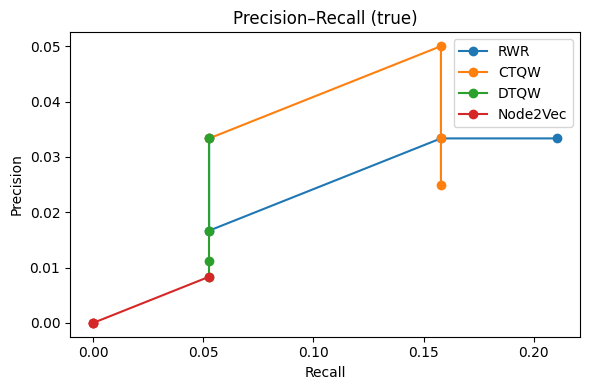

In [33]:
def plot_precision_recall(df, control="true"):
    fig, ax = plt.subplots(figsize=(6, 4))

    for method in methods.keys():
        rec = df[
            (df.method == method) &
            (df.control == control) &
            (df.metric == "recall")
        ].sort_values("k")

        prec = df[
            (df.method == method) &
            (df.control == control) &
            (df.metric == "precision")
        ].sort_values("k")

        ax.plot(
            rec["mean"],
            prec["mean"],
            marker="o",
            label=method
        )

    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title(f"Precision–Recall ({control.replace('_',' ')})")
    ax.legend()
    plt.tight_layout()
    plt.show()

plot_precision_recall(df, control="true")

In [34]:
seeds = set(subgraph_source) & set(subgraph.nodes)
targets = set(subgraph_target) & set(subgraph.nodes)

# index space
seed_indices = {node2i[v] for v in seeds}
target_indices = {node2i[v] for v in targets}

candidate_indices = [
    node2i[v] for v in nodes if v not in seeds
]
print(np.unique(np.round(dtqw_scores[candidate_indices], 6)).shape)
print(np.std(dtqw_scores[candidate_indices]))
print(np.isnan(dtqw_scores).sum(), np.isinf(dtqw_scores).sum())

(578,)
0.12697888738294882
0 0


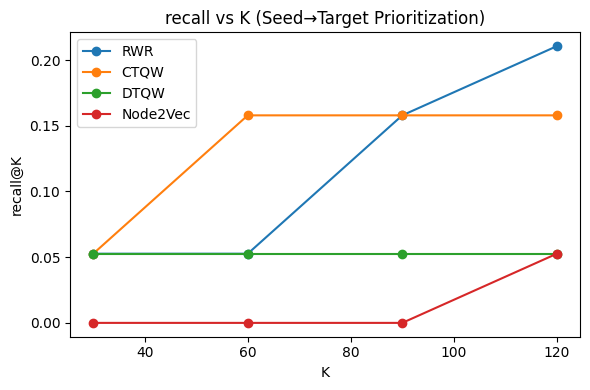

In [35]:
def plot_precision_vs_k(df, metric='precision', control="true"):

    plt.figure(figsize=(6,4))

    for method in df.method.unique():
        subset = df[
            (df.method == method) &
            (df.control == control) &
            (df.metric == metric)
        ].sort_values("k")

        plt.plot(
            subset["k"],
            subset["mean"],
            marker="o",
            label=method
        )

    plt.xlabel("K")
    plt.ylabel(metric + "@K")
    plt.title(metric + " vs K (Seed→Target Prioritization)")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_precision_vs_k(df, metric='recall')

In [36]:

def compute_delta_precision(df, k_values, metric='precision'):
    rows = []

    for method in df["method"].unique():
        for k in k_values:
            try:
                p_true = df.loc[
                    (df.method == method) &
                    (df.control == "true") &
                    (df.metric == metric) &
                    (df.k == k),
                    "mean"
                ].values[0]

                p_dist = df.loc[
                    (df.method == method) &
                    (df.control == "distance_matched") &
                    (df.metric == metric) &
                    (df.k == k),
                    "mean"
                ].values[0]

                rows.append({
                    "method": method,
                    "k": k,
                    "delta_precision": p_true - p_dist
                })

            except IndexError:
                # in case something is missing
                continue

    return pd.DataFrame(rows)

delta_p_df = compute_delta_precision(df, k_values=[30,60,90,120])

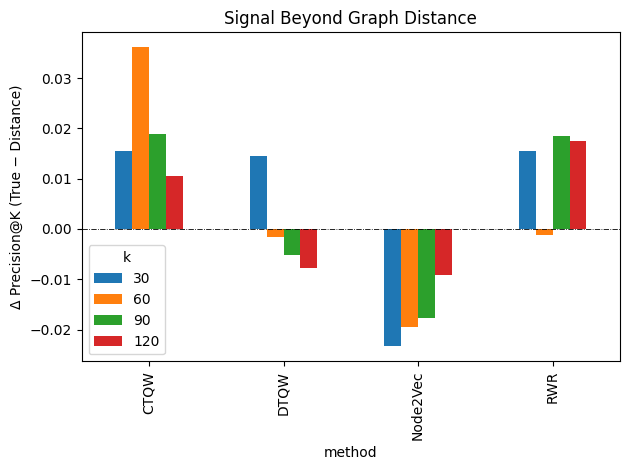

In [37]:
delta_p_df.pivot(index="method", columns="k", values="delta_precision").plot.bar()
plt.axhline(0, color="black", ls='-.', linewidth=0.6)
plt.ylabel("Δ Precision@K (True − Distance)")
plt.title("Signal Beyond Graph Distance")
plt.tight_layout()
plt.show()